# 🤖 Model Training & Evaluation
## Student Dropout Prediction Project

**Goal:** Train multiple machine learning models, compare their performance, and select the best one for deployment.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
import joblib
import sys
import os
import importlib
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append('..')
import config
importlib.reload(config)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Processed Data

In [2]:
try:
    train_df = pd.read_csv(config.TRAIN_DATA_PATH)
    test_df = pd.read_csv(config.TEST_DATA_PATH)
    
    X_train = train_df.drop(columns=['Target'])
    y_train = train_df['Target']
    X_test = test_df.drop(columns=['Target'])
    y_test = test_df['Target']
    
    print(f"✓ Data loaded successfully")
    print(f"Train shape: {X_train.shape}")
    print(f"Test shape:  {X_test.shape}")
except FileNotFoundError:
    print("❌ Error: Processed data not found. Run 02_data_preprocessing.ipynb first.")

✓ Data loaded successfully
Train shape: (10783, 21)
Test shape:  (2696, 21)


## 2. Define Models

In [3]:
models = {
    'Logistic Regression': LogisticRegression(**config.LR_PARAMS),
    'Decision Tree': DecisionTreeClassifier(**config.DT_PARAMS),
    'Random Forest': RandomForestClassifier(**config.RF_PARAMS),
    'XGBoost': XGBClassifier(**config.XGBOOST_PARAMS),
    'SVM': SVC(**config.SVM_PARAMS, probability=True)
}

print(f"Defined {len(models)} models for training.")

Defined 5 models for training.


## 3. Train and Evaluate Models

### results = []
trained_models = {}

print("Training models...\n")

for name, model in models.items():
    print(f"⏳ Training {name}...")
    
    # Train
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-Validation (5-fold)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_acc = cv_scores.mean()
    
    results.append({
        'Model': name,
        'Test Accuracy': acc,
        'CV Accuracy': cv_acc,
        'F1 Score': f1
    })
    
    print(f"   ✓ Test Acc: {acc:.4f} | CV Acc: {cv_acc:.4f}")

# Create comparison dataframe
results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)
print("\n🏆 Model Comparison:")
display(results_df)

## 4. Visualize Performance

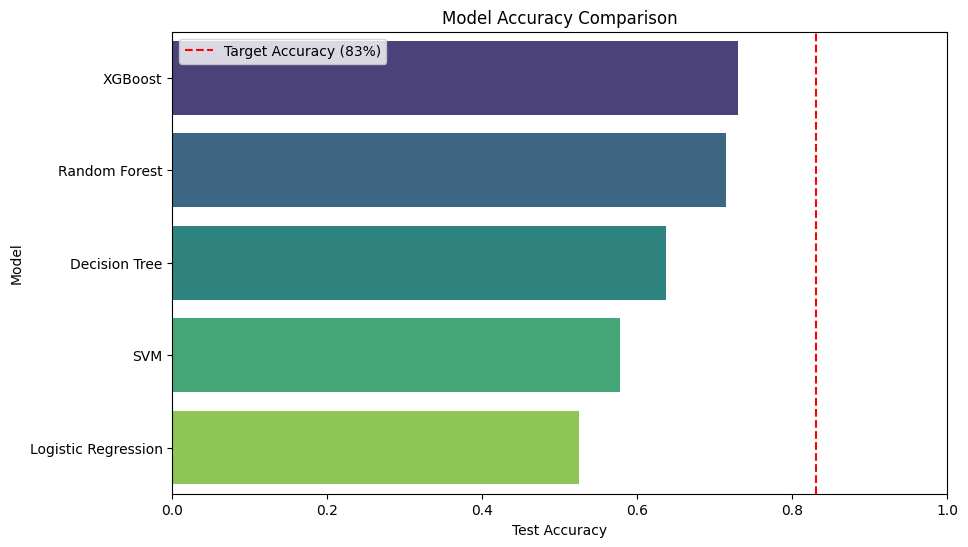

In [5]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Test Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1.0)
plt.axvline(x=0.83, color='r', linestyle='--', label='Target Accuracy (83%)')
plt.legend()
plt.show()

## 5. Confusion Matrix (Best Model)

Detailed Report for Best Model: XGBoost
              precision    recall  f1-score   support

     Dropout       0.77      0.63      0.69       898
    Enrolled       0.74      0.76      0.75       899
    Graduate       0.70      0.80      0.75       899

    accuracy                           0.73      2696
   macro avg       0.73      0.73      0.73      2696
weighted avg       0.73      0.73      0.73      2696



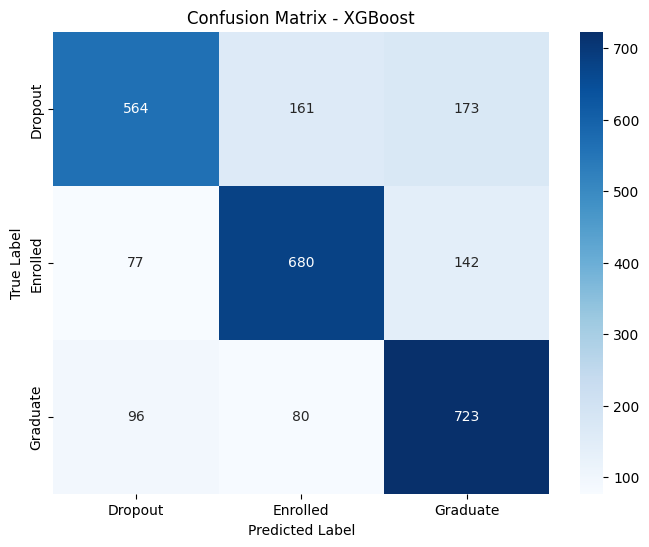

In [6]:
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"Detailed Report for Best Model: {best_model_name}")
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Dropout', 'Enrolled', 'Graduate']))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Feature Importance

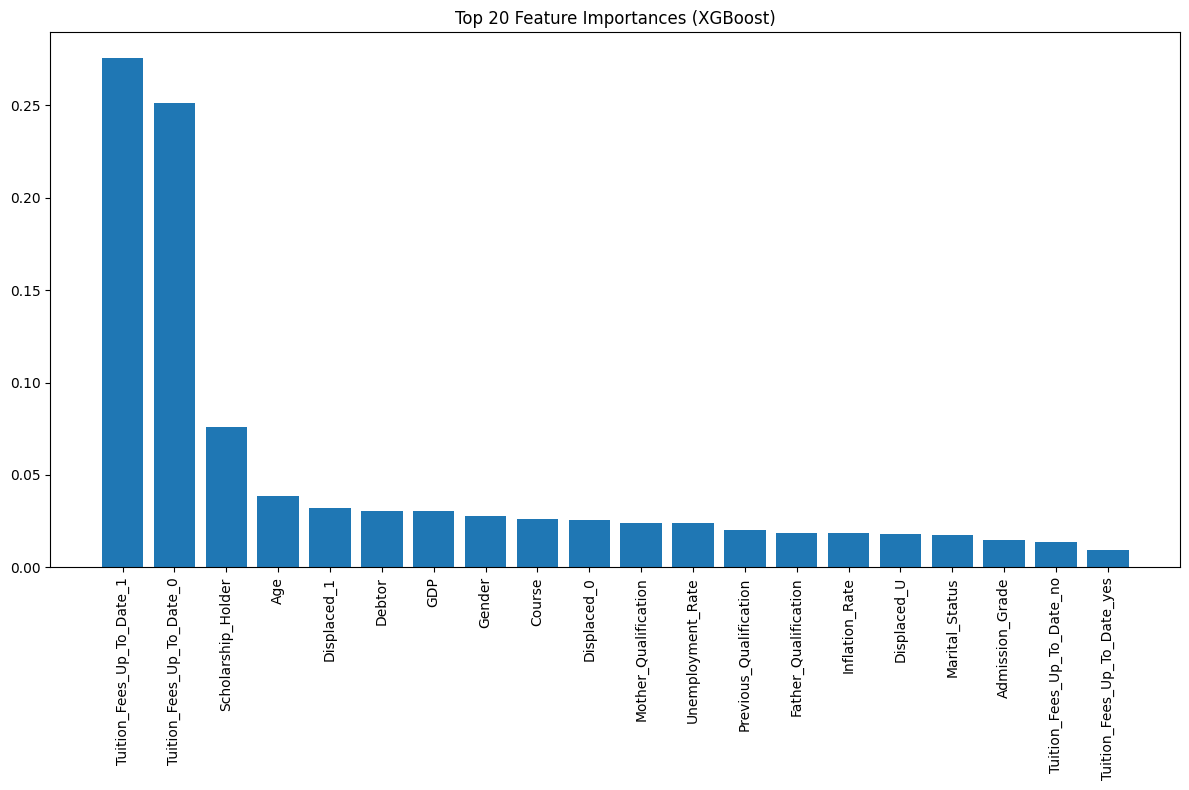

In [7]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Top 20 features
    top_n = 20
    plt.figure(figsize=(12, 8))
    plt.title(f'Top {top_n} Feature Importances ({best_model_name})')
    plt.bar(range(top_n), importances[indices[:top_n]], align='center')
    plt.xticks(range(top_n), [X_train.columns[i] for i in indices[:top_n]], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not provide feature importances directly.")

## 7. Save Best Model

In [8]:
save_path = config.MODEL_DIR / f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model, save_path)
print(f"✓ Saved best model to: {save_path}")

# Also save as generic 'best_model.pkl' for app usage
joblib.dump(best_model, config.MODEL_DIR / "best_model.pkl")
print(f"✓ Saved as default model for app.")

✓ Saved best model to: D:\Santosh_minor\notebooks\..\models\best_model_xgboost.pkl
✓ Saved as default model for app.
